# CNN 2D layers for three-second splits

~80% validation accuracy

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import pandas as pd
import numpy as np

In [2]:
import pickle

infile = open("Preprocessed/mfcc_list_time-series_639450_10_60",'rb')
mfcc_list = pickle.load(infile)
infile.close()

In [3]:
df = pd.read_csv("Data/features_30_sec.csv")

In [4]:
df['labels'] = range(0, 1000)

In [5]:
mfcc_list = mfcc_list.merge(df, on="labels", how="left")

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mfcc_list.mfcc, mfcc_list.label, test_size=0.2, random_state=42
)

y_test_keep = y_test

In [30]:
X_all = mfcc_list.mfcc
y_all = mfcc_list.label

In [7]:
from sklearn.preprocessing import LabelBinarizer

le = LabelBinarizer()
y_train = le.fit_transform(y_train.values)
y_test = le.transform(y_test.values)

In [31]:
le_all = LabelBinarizer()
y_all_labelled = le_all.fit_transform(y_all.values)

In [8]:
class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.hidden_size = 1290
        drp = 0.1
        n_classes = 10
        self.fc1 = nn.Linear(125*60, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)
        # self.softmax = nn.Softmax(n_classes)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        fc1 = self.dropout(self.relu(self.fc1(x)))
        fc2 = self.dropout(self.relu(self.fc2(fc1)))
        fc3 = self.dropout(self.relu(self.fc3(fc2)))
        fc4 = self.dropout(self.relu(self.fc4(fc3)))
        fc5 = self.dropout(self.relu(self.fc5(fc4)))
        out = self.out(fc5)
        return out

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        drp = 0.1
        n_classes = len(le.classes_)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        
        self.cnn_layer1 = nn.Sequential(
            # Layer 1
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Dropout(drp),
            # Layer 2
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Dropout(drp),
            # Layer 3
            nn.Conv2d(32, 32, kernel_size=(3, 4), stride=2, padding=0),
            # Out: 62, 29
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(4, 3), stride=2, padding=0),
            # Out: 30, 14
            nn.Dropout(drp),
        )
        
        self.cnn_layer2 = nn.Sequential(
            # Layer 1
            nn.Conv2d(1, 32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=7, stride=1, padding=3),
            nn.Dropout(drp),
            # Layer 2
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=5, stride=1, padding=2),
            nn.Dropout(drp),
            # Layer 3
            nn.Conv2d(32, 32, kernel_size=(3, 4), stride=2, padding=0),
            # Out: 62, 29
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(4, 3), stride=2, padding=0),
            # Out: 30, 14
            nn.Dropout(drp),
        )
        
        # self.cnn_layer2 = nn.Sequential(
        #     # Layer 1
        #     nn.Conv1d(40, 40, kernel_size=5, stride=1, padding=2),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp),
        # )
        
        # self.cnn_layer2 = nn.Sequential(
        #     # Layer 2
        #     nn.Conv1d(40, 40, kernel_size=249, stride=1, padding=124),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp),
        # )
        # self.cnn_layer3 = nn.Sequential(
        #     # Layer 3
        #     nn.Conv1d(40, 40, kernel_size=125, stride=1, padding=62),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp),
        # )
        # self.cnn_layer4 = nn.Sequential(
        #     # Layer 4
        #     nn.Conv1d(40, 40, kernel_size=59, stride=1, padding=29),
        #     nn.BatchNorm1d(40),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(drp)
        # )
        
        self.fc1 = nn.Linear(30 * 14 * 32 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)
        self.directout = nn.Linear(512, n_classes)

    def forward(self, x):
        # x = x.view(x.shape[0], 40, 125)
        x = torch.unsqueeze(x, dim = 1)
        out1 = self.cnn_layer1(x)
        # out1 = self.cnn_layer1(out1)
        out2 = self.cnn_layer2(x)
        # out3 = self.cnn_layer3(x)
        # out4 = self.cnn_layer4(x)
        full_out = torch.cat([out1, out2], dim=1)
        full_out = full_out.view(full_out.size(0), -1)
        x = torch.flatten(full_out, start_dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        out = self.out(x)
        return out

In [10]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = F.softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    _, y_test_tags = torch.max(y_test, dim = 1) 
    
    correct_pred = (y_pred_tags == y_test_tags).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return y_pred_softmax, acc

In [25]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 35
batch_size = 32
model = CNN()
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
)

model.to(device)

# Load train and test in CUDA Memory
x_train = torch.tensor(X_train.values.tolist(), dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
x_cv = torch.tensor(X_test.values.tolist(), dtype=torch.float).to(device)
y_cv = torch.tensor(y_test, dtype=torch.float).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train_tensor)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.0
    accuracy = []
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # # Casting
        # x_batch = x_batch.to(device)
        # y_batch = y_batch.type(torch.LongTensor)
        # y_batch = y_batch.to(device)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        _, acc = multi_acc(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
        accuracy.append(acc.item())

    # Set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.0
    val_accuracy = []
    val_preds = np.zeros((len(x_cv), 10))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        # Casting
        # x_batch = x_batch.to(device)
        # y_batch = y_batch.type(torch.LongTensor)
        # y_batch = y_batch.to(device)
        # Detach
        y_pred = model(x_batch).detach()
        val_pred, val_acc = multi_acc(y_pred, y_batch)
        val_preds[i * batch_size:(i+1) * batch_size] = val_pred.cpu()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        val_accuracy.append(val_acc.item())

    # Check Accuracy
    # val_accuracy = sum(val_preds.argmax(axis=1) == y_test) / len(y_test)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print(
        "Epoch {}/{} \t loss={:.4f} \t acc={:.2f}% \t val_loss={:.4f} \t val_acc={:.2f}% \t time={:.2f}s".format(
            epoch + 1, n_epochs, avg_loss, np.mean(accuracy), avg_val_loss, np.mean(val_accuracy), elapsed_time
        )
    )


Epoch 1/35 	 loss=56.9066 	 acc=32.14% 	 val_loss=42.3303 	 val_acc=49.24% 	 time=13.09s
Epoch 2/35 	 loss=42.0273 	 acc=51.08% 	 val_loss=37.3458 	 val_acc=55.13% 	 time=13.08s
Epoch 3/35 	 loss=36.3407 	 acc=59.10% 	 val_loss=34.9251 	 val_acc=59.78% 	 time=13.11s
Epoch 4/35 	 loss=32.1488 	 acc=65.76% 	 val_loss=28.6734 	 val_acc=69.00% 	 time=13.12s
Epoch 5/35 	 loss=28.6130 	 acc=69.22% 	 val_loss=26.6675 	 val_acc=70.71% 	 time=13.12s
Epoch 6/35 	 loss=26.5217 	 acc=71.99% 	 val_loss=26.3399 	 val_acc=72.11% 	 time=13.13s
Epoch 7/35 	 loss=23.7951 	 acc=74.47% 	 val_loss=26.5113 	 val_acc=72.24% 	 time=13.15s
Epoch 8/35 	 loss=22.1860 	 acc=77.00% 	 val_loss=23.0919 	 val_acc=75.86% 	 time=13.16s
Epoch 9/35 	 loss=20.8610 	 acc=78.25% 	 val_loss=24.6684 	 val_acc=74.71% 	 time=13.17s
Epoch 10/35 	 loss=19.2627 	 acc=79.64% 	 val_loss=22.2573 	 val_acc=78.46% 	 time=13.16s
Epoch 11/35 	 loss=17.4747 	 acc=81.28% 	 val_loss=21.3100 	 val_acc=78.71% 	 time=13.18s
Epoch 12/35 	 loss=

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_graph(epochs):
    plt.figure(figsize=(12,12))
    sns.set_style("ticks")
    plt.style.library['seaborn-colorblind'] # Care for the color-blind :")
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

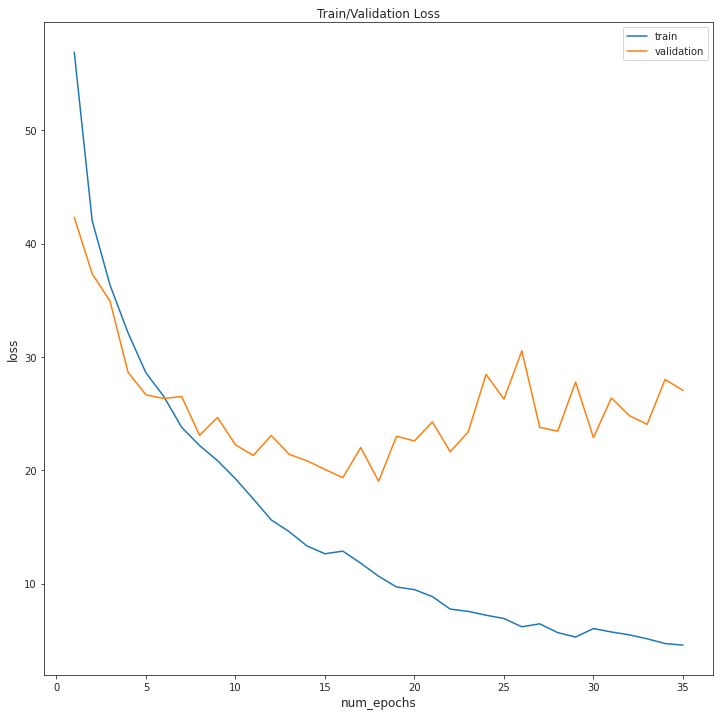

In [27]:
plot_graph(n_epochs)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

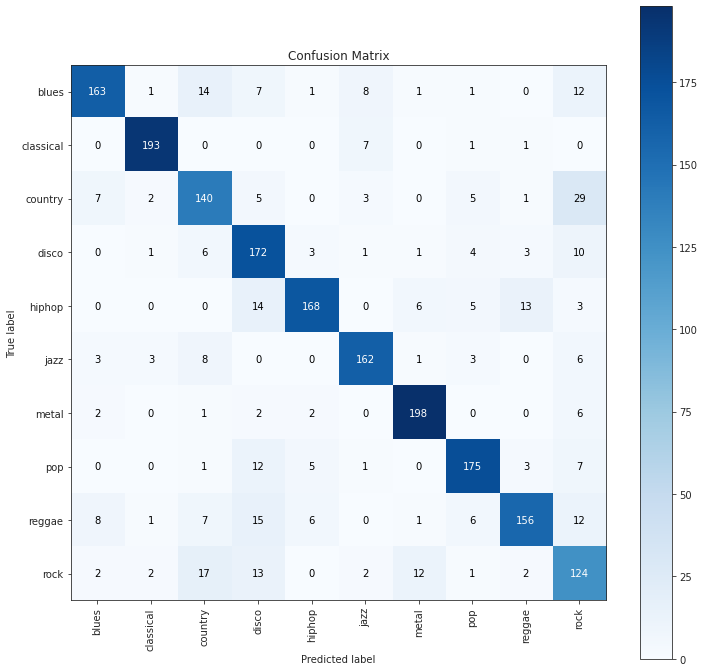

In [28]:
import scikitplot as skplt
y_true = [x for x in y_test_keep.tolist()]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [ ]:
data, sr = librosa.load("Data/genres_original/blues/blues.00000.wav")

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       blues       0.88      0.78      0.83       208
   classical       0.95      0.96      0.95       202
     country       0.72      0.73      0.73       192
       disco       0.72      0.86      0.78       201
      hiphop       0.91      0.80      0.85       209
        jazz       0.88      0.87      0.88       186
       metal       0.90      0.94      0.92       211
         pop       0.87      0.86      0.86       204
      reggae       0.87      0.74      0.80       212
        rock       0.59      0.71      0.65       175

    accuracy                           0.83      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.83      0.83      2000



Training on the whole dataset. Training on only around 15 epochs as seen from the graphs above.

In [34]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 15
batch_size = 32
model = CNN()
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
)

model.to(device)

# Load train in CUDA Memory
x_train = torch.tensor(X_all.values.tolist(), dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_all_labelled, dtype=torch.float).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train_tensor)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

train_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.0
    accuracy = []
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # # Casting
        # x_batch = x_batch.to(device)
        # y_batch = y_batch.type(torch.LongTensor)
        # y_batch = y_batch.to(device)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        _, acc = multi_acc(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
        accuracy.append(acc.item())

    # Check Accuracy
    # val_accuracy = sum(val_preds.argmax(axis=1) == y_test) / len(y_test)
    train_loss.append(avg_loss)
    elapsed_time = time.time() - start_time
    print(
        "Epoch {}/{} \t loss={:.4f} \t acc={:.2f}% \t time={:.2f}s".format(
            epoch + 1, n_epochs, avg_loss, np.mean(accuracy), elapsed_time
        )
    )


Epoch 1/15 	 loss=56.6238 	 acc=32.52% 	 time=15.30s
Epoch 2/15 	 loss=41.8145 	 acc=52.15% 	 time=15.28s
Epoch 3/15 	 loss=35.1913 	 acc=61.44% 	 time=15.30s
Epoch 4/15 	 loss=31.6425 	 acc=66.35% 	 time=15.31s
Epoch 5/15 	 loss=28.7929 	 acc=69.42% 	 time=15.32s
Epoch 6/15 	 loss=25.9301 	 acc=72.81% 	 time=15.34s
Epoch 7/15 	 loss=22.8200 	 acc=75.89% 	 time=15.34s
Epoch 8/15 	 loss=21.4071 	 acc=78.13% 	 time=15.35s
Epoch 9/15 	 loss=20.1004 	 acc=79.52% 	 time=15.35s
Epoch 10/15 	 loss=17.6067 	 acc=81.63% 	 time=15.38s
Epoch 11/15 	 loss=16.6064 	 acc=83.03% 	 time=15.40s
Epoch 12/15 	 loss=14.8394 	 acc=84.42% 	 time=15.40s
Epoch 13/15 	 loss=14.6682 	 acc=85.62% 	 time=15.40s
Epoch 14/15 	 loss=13.1340 	 acc=86.42% 	 time=15.40s
Epoch 15/15 	 loss=12.7742 	 acc=87.32% 	 time=15.41s


In [36]:
torch.save(model, "Models/CNN_2D_Split_10.pt")